<a href="https://colab.research.google.com/github/randreove/TS/blob/main/notebooks/60_Forecasting%20II%20Deep%20Learning/3_Model%20Evaluation/B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Evaluation

In [1]:
!git clone https://github.com/randreove/TS.git

Cloning into 'TS'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (379/379), done.
remote: Compressing objects: 100% (292/292), done.
remote: Total 379 (delta 108), reused 320 (delta 62), pack-reused 0 (from 0)
Receiving objects: 100% (379/379), 27.43 MiB | 6.59 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Error downloading object: data/airline-passengers.csv (9a2458b): Smudge error: Error downloading data/airline-passengers.csv (9a2458bb78a743a621f4cc5ad64c73530ecaa2bf39b62979d8e8bdf13291db1d): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/TS/.git/lfs/logs/20241106T083030.032110407.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: data/airline-passengers.csv: smudge filter lfs failed
You can inspect what was checked out with 'git status'
and retry with 'git restore --sour

## Load Dataset

In [5]:
import pandas as pd
df = pd.read_csv('/content/precio_mercado_diario.csv', parse_dates=['datetime_utc'], index_col=0)
df = df.loc["2020":].copy()
df

,Mercado SPOT
datetime_utc,
2020-01-01 00:00:00+00:00,38.60
2020-01-01 01:00:00+00:00,36.55
2020-01-01 02:00:00+00:00,32.32
2020-01-01 03:00:00+00:00,30.85
2020-01-01 04:00:00+00:00,30.14
...,...
2023-08-04 17:00:00+00:00,70.00
2023-08-04 18:00:00+00:00,86.30
2023-08-04 19:00:00+00:00,94.00


## Data Preprocessing

In [6]:
### Data Numpy Array
data_array = df.values

### Train Test Split
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_array, test_size=0.2, shuffle=False)

### Create Sequences
import numpy as np
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24 # Use 24 hours prior to predict the following hour
X_train, y_train = create_sequences(train, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)

## Modelling

### Design NN Architecture

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

model = Sequential(layers=[
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

### Train Model

In [8]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)
history = model.fit(
    X_train, y_train, epochs=50, batch_size=64, verbose=0,
    validation_data=(X_test, y_test), callbacks=[early_stop])

### Calculate Predictions

In [9]:
y_pred = model.predict(X_test)
y_pred

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[123.98387 ],
       [102.516304],
       [ 86.78051 ],
       ...,
       [ 93.18176 ],
       [ 93.51023 ],
       [ 89.0335  ]], dtype=float32)

## Comparison: Real Data & Prediction

### Create DataFrame

In [10]:
import sys
sys.path.append('../')

In [13]:
import pandas as pd

def process_df_pred(df, y_true, dic_pred):
    """
    Toma un DataFrame original con un índice de fechas más amplio, los valores reales de y_test
    y un diccionario de predicciones. Devuelve un DataFrame con el índice de fechas correspondiente
    a los valores de y_true y las predicciones.

    Parámetros:
    - df: DataFrame original con un índice de fechas.
    - y_true: Serie o array de valores reales (y_test).
    - dic_pred: Diccionario con predicciones, donde la clave es el nombre del modelo y el valor es la Serie o array de predicciones.

    Retorna:
    - DataFrame con el índice de fechas y columnas de valores reales y predicciones.
    """
    # Asegurarse de que y_true sea 1D
    if len(y_true.shape) > 1:
        y_true = y_true.ravel()

    # Asegurar que cada predicción en dic_pred sea 1D
    for model_name in dic_pred:
        if len(dic_pred[model_name].shape) > 1:
            dic_pred[model_name] = dic_pred[model_name].ravel()

    # Suponemos que y_true y dic_pred tienen un índice que coincide con una parte del índice de df
    common_index = df.index[-len(y_true):]  # Toma las últimas posiciones para que coincidan con y_true

    # Crear un DataFrame base con el índice común y y_true
    df_result = pd.DataFrame(index=common_index, data={'y_true': y_true})

    # Añadir las predicciones al DataFrame
    for model_name, pred in dic_pred.items():
        df_result[model_name] = pred

    return df_result

# Ejemplo de uso:
# resultado = process_df_pred(df, y_test, dic_pred)

In [15]:
dic_pred = {
    'y_pred': y_pred
}

df_pred = process_df_pred(df, y_true=y_test, dic_pred=dic_pred)

# df_pred = y_test.copy()
df_pred

,y_true,y_pred
datetime_utc,,
2022-11-15 22:00:00+00:00,105.00,123.983871
2022-11-15 23:00:00+00:00,90.52,102.516304
2022-11-16 00:00:00+00:00,87.00,86.780510
2022-11-16 01:00:00+00:00,85.00,84.669579
2022-11-16 02:00:00+00:00,84.92,82.683372
...,...,...
2023-08-04 17:00:00+00:00,70.00,63.083851
2023-08-04 18:00:00+00:00,86.30,82.598625
2023-08-04 19:00:00+00:00,94.00,93.181763


In [11]:
# import utils

dic_pred = {
    'y_pred': y_pred
}

df_pred = utils.process_df_pred(df, y_test, dic_pred)
df_pred

ModuleNotFoundError: No module named 'utils'

### Visualize Data

#### All Hours

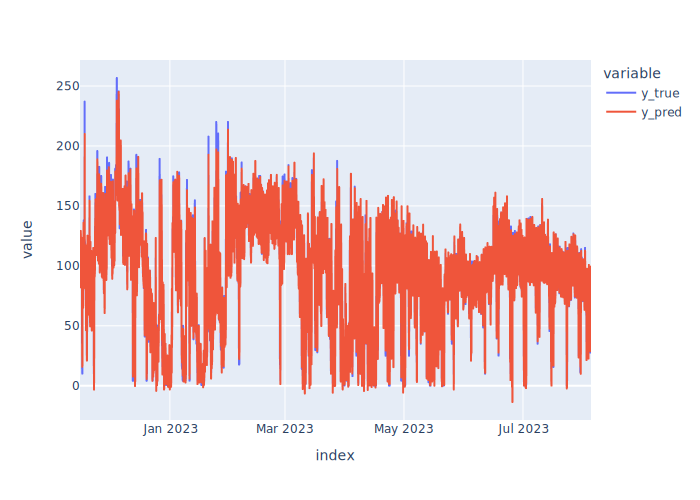

In [ ]:
utils.plot_df(df_pred)

In [16]:
import matplotlib.pyplot as plt

def plot_predictions(df_pred):
    """
    Genera una gráfica de los valores reales y las predicciones.

    Parámetros:
    - df_pred: DataFrame que contiene la columna 'y_true' con los valores reales y
               otras columnas con las predicciones de distintos modelos.
    """
    plt.figure(figsize=(14, 7))

    # Graficar la columna de valores reales
    plt.plot(df_pred.index, df_pred['y_true'], label='Valores Reales (y_test)', linewidth=2, color='red')

    # Graficar cada columna de predicciones
    for col in df_pred.columns:
        if col != 'y_true':
            plt.plot(df_pred.index, df_pred[col], label=f'Predicción: {col}')

    plt.title('Comparación de Valores Reales y Predicciones')
    plt.xlabel('Fecha')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejemplo de uso:
# plot_predictions(df_pred)

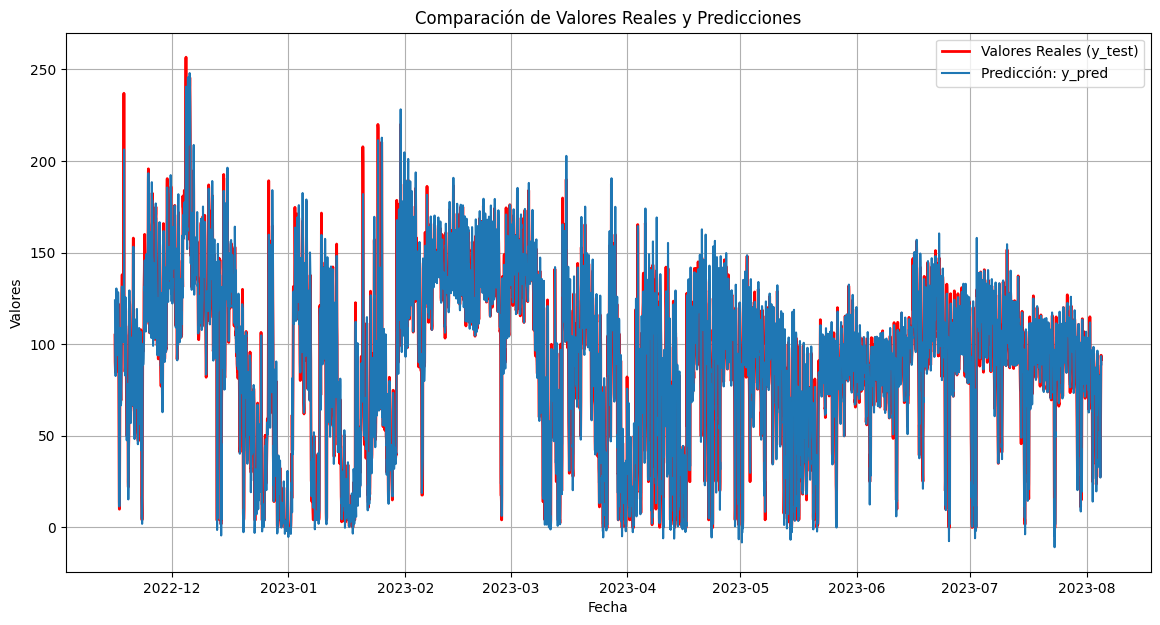

In [17]:
plot_predictions(df_pred)

#### Last 2 Days

In [18]:
df_pred_2 = df_pred.loc['2023-08-02':].copy()
df_pred_2

,y_true,y_pred
datetime_utc,,
2023-08-02 00:00:00+00:00,96.09,94.581215
2023-08-02 01:00:00+00:00,96.09,93.591759
2023-08-02 02:00:00+00:00,94.09,94.468193
2023-08-02 03:00:00+00:00,94.09,94.705910
2023-08-02 04:00:00+00:00,93.86,96.234207
...,...,...
2023-08-04 17:00:00+00:00,70.00,63.083851
2023-08-04 18:00:00+00:00,86.30,82.598625
2023-08-04 19:00:00+00:00,94.00,93.181763


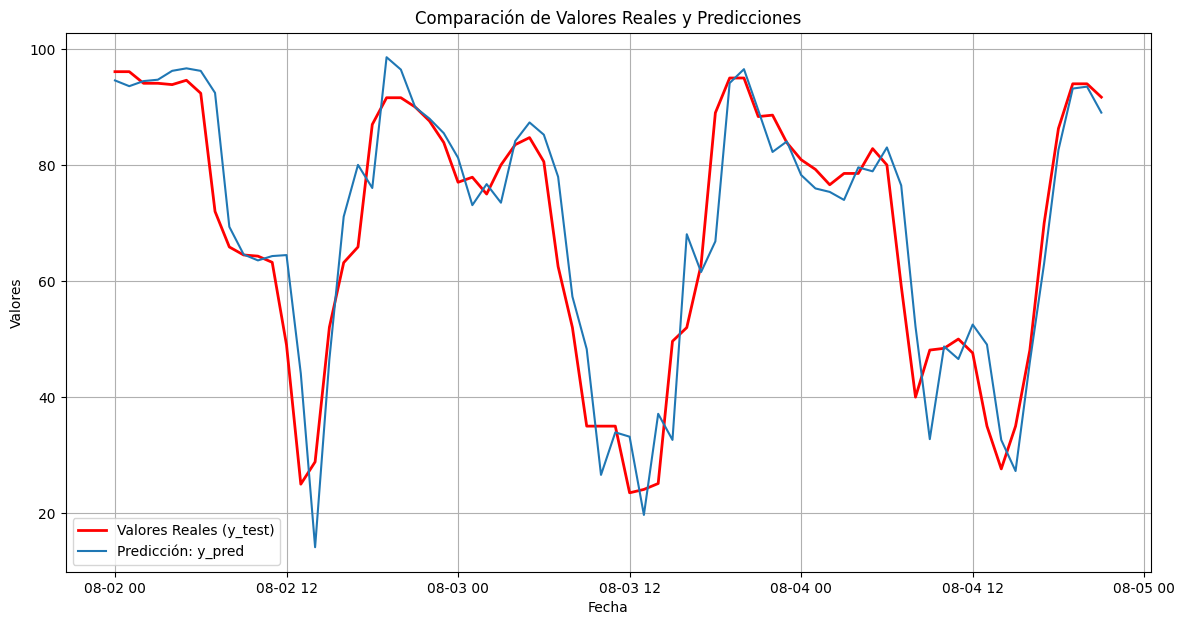

In [19]:
# utils.plot_df(df_pred_2)
plot_predictions(df_pred_2)

## Metrics to Measure Model Error

### Mean Squared Error

In [20]:
df_pred['error'] = df_pred.y_true - df_pred.y_pred
df_pred['error2'] = df_pred['error']**2
MSE = df_pred.error2.mean()
MSE

125.16216233990644

### Mean Absolute Error

In [21]:
df_pred['error'] = df_pred.y_true - df_pred.y_pred
df_pred['error_abs'] = df_pred['error'].abs()
MAE = df_pred.error_abs.mean()
MAE

7.378107536297112

### Root Mean Squared Error

In [22]:
RMSE = np.sqrt(MSE)
RMSE

11.187589657290191

### Scikit-Learn Metrics

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_true=df_pred.y_true, y_pred=df_pred.y_pred)
mse = mean_squared_error(y_true=df_pred.y_true, y_pred=df_pred.y_pred)
rmse = mean_squared_error(y_true=df_pred.y_true, y_pred=df_pred.y_pred, squared=False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
mae

7.378107536297112

In [25]:
mse

125.16216233990644

In [26]:
rmse

11.187589657290191